In [1]:
import os
import glob
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D
import pydotplus 

import lane

# Features Extraction

In [2]:
def read_image(path):
    return(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB))

def extract_hog(img, pix_per_cell=8, cell_per_block=2, orient=9, hog_idx=None):
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, visualise=False, feature_vector=True)
    if hog_idx is None:
        return hog_features
    else:
        return hog_features[hog_idx]
    
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range, density=True)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range, density=True)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range, density=True)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial_color_hist(img, color_space='LUV', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)             
    
    # color histogram
    hist_features=color_hist(feature_image)
    return (hist_features)
    # Use cv2.resize().ravel() to create the feature vector
    #spatial_features = cv2.resize(feature_image, size).ravel() 

    #return np.concatenate((spatial_features, hist_features))


def extract_features(img, feature='hog', color_space='YUV', size=(32, 32), hog_idx=None):    
    
    hog_features=extract_hog(img, hog_idx=hog_idx)
    
    if feature=='hog':
        return hog_features
    
    color_features=bin_spatial_color_hist(img, color_space, size)    

    features=np.concatenate((hog_features, color_features))    
    
    return features


In [3]:
def extract_pack_features(features, color_space, datasets_path, subdir_lists, hog_idx=None):

    x = []

    for subpath in subdir_lists:
        fcount=len(glob.glob1(datasets_path+subpath,'*.png'))
        for i, fname in enumerate(glob.iglob(datasets_path+subpath+'/*.png')): 
            img=read_image(fname)
            x.append(extract_features(img,feature=features,color_space=color_space, hog_idx=hog_idx))

    return x
    
def normalise_histogram(hist):
    # normalise histogram (0,1) to (-1,1)
    return (2*hist-1)

def process_datasets(features='hog', hog_idx=None, color_space='YUV'):
    
    # Vehicles
    subdir_lists=['KITTI_extracted','GTI_MiddleClose','GTI_Right','GTI_Left','GTI_Far']
    datasets_path='./datasets/vehicles/'
    
    x_pos = extract_pack_features(features, color_space, datasets_path, subdir_lists, hog_idx)

    # Non-vehicles
    datasets_path='./datasets/non-vehicles/'
    subdir_lists=['Extras','GTI','syc']

    x_neg = extract_pack_features(features, color_space, datasets_path, subdir_lists, hog_idx)

    # Stack both vehicle and non-vehicle datasets 

    x=np.vstack((x_pos,x_neg)).astype(np.float64)
        
    y=np.hstack((np.ones([len(x_pos)], dtype=int), 
                 np.zeros([len(x_neg)], dtype=int)))
        
    # Normalise features
    #X_scaler=StandardScaler().fit(x)
    #scaled_X=X_scaler.transform(x)
    scaled_X=normalise_histogram(x)
    
    # Shuffle and split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2)

    return X_train, X_test, y_train, y_test



In [4]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=1):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_hog_block(img_path):

    img=read_image(img_path)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    cell_per_block=1
    pix_per_cell=16
    orient=18
    block_per_row=64/pix_per_cell

    hog_features, hog_img = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=True)
    #hog_features, hog_img = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    print(min(hog_features), max(hog_features))
    #plt.plot(hog_features[5,7].ravel())
    #plt.show()

    hog_img=hog_img*255/np.max(hog_img)
    hog_img=cv2.cvtColor(hog_img.astype(np.uint8),cv2.COLOR_GRAY2BGR)


    for hog_feat_idx in [81]:
        block=(hog_feat_idx/orient)
        block_row=int((block/block_per_row))
        block_col=int(np.remainder(block,block_per_row))
        #print(block, block_row, block_col)
        top_left_corner=(block_col*pix_per_cell,block_row*pix_per_cell)
        bottom_right_corner=(top_left_corner[0]+pix_per_cell,top_left_corner[1]+pix_per_cell)
        #print(top_left_corner, bottom_right_corner)
        img=draw_boxes(img, [((top_left_corner), (bottom_right_corner))])
        hog_img=draw_boxes(hog_img, [((top_left_corner), (bottom_right_corner))])


    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.show()

0.0 0.513743821887


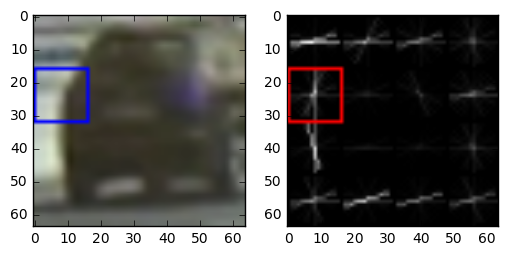

0.0019426608519 0.290354542184


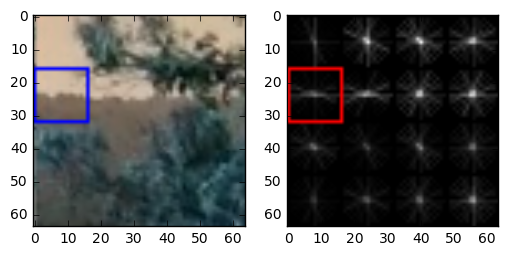

In [5]:
img_path=os.getcwd()+'/datasets/vehicles/GTI_Left/image0019.png'
draw_hog_block(img_path)

img_path=os.getcwd()+'/datasets/non-vehicles/Extras/extra9.png'
draw_hog_block(img_path)

# Decision Tree
We use decision tree to examine which HOG feature is important. We will then use this information to explore pruning i.e. removing features that are not important, which can show significant reductino in the feature and hence improved computational time.

In [5]:
from sklearn import tree
X_train, X_test, y_train, y_test=process_datasets(features='hog',hog_idx=None)
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

pred=clf.predict(X_test)
accuracy=np.mean(pred==y_test)
print(accuracy)

tree.export_graphviz(clf, out_file='tree.dot')

KeyboardInterrupt: 

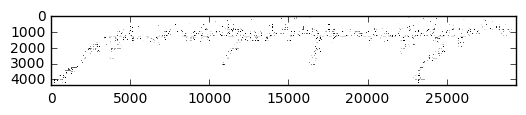

In [7]:
# Use command line to plot tree in image
#dot -Tpng tree.dot -o tree.png

plt.imshow(mpimg.imread('tree.png'))
plt.show()

#### Illutrate the HoG block that matters the most to making decision on a vehicle and a non-vehicle image. 

## Decision Tree Pruning
Now try to fit decision tree using only 1 bin of HOG from previous result. The accuracy is the same as previously!

In [96]:
X_train, X_test, y_train, y_test=process_datasets(features='hog_and_color',hog_idx=[81])
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

pred=clf.predict(X_test)
accuracy=np.mean(pred==y_test)
print('Test accuracy', accuracy)

KeyboardInterrupt: 

# SVM


In [6]:
def predict_vehicle(clf, image):
    image=cv2.resize(image,(64,64))
    feat=extract_features(image, feature='hog_and_color', color_space='LUV')

    feat=feat.reshape(1,-1)   
    #scaler=StandardScaler().fit(feat.astype(np.float64))    
    #feat=scaler.transform(feat)
    feat=normalise_histogram(feat)
    return(clf.predict(feat))
    

In [ ]:
X_train, X_test, y_train, y_test=process_datasets(features='hog_and_color', color_space='LUV')

clf=svm.SVC(kernel='linear')
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
val_acc=accuracy_score(y_test, y_pred)
print('Validation accuray %.4f'%val_acc)

In [ ]:
img_path='./datasets/non-vehicles/GTI/image1.png'
#img_path='./datasets/vehicles/KITTI_extracted/1.png'

img=read_image(img_path)

plt.imshow(img)
plt.show()

print(predict_vehicle(clf, img))


## Sliding Windows

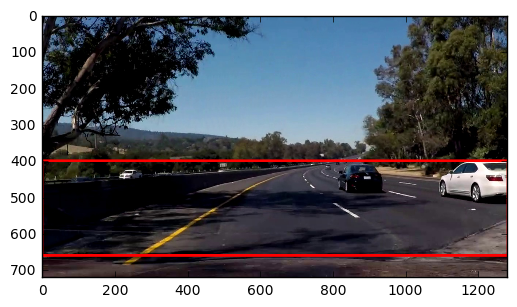

./datasets/non-vehicles/syc/img3825.png
./datasets/non-vehicles/syc/img3826.png
./datasets/non-vehicles/syc/img3827.png
./datasets/non-vehicles/syc/img3828.png
./datasets/non-vehicles/syc/img3829.png
./datasets/non-vehicles/syc/img3830.png
./datasets/non-vehicles/syc/img3831.png
./datasets/non-vehicles/syc/img3832.png
./datasets/non-vehicles/syc/img3833.png
./datasets/non-vehicles/syc/img3834.png
./datasets/non-vehicles/syc/img3835.png
./datasets/non-vehicles/syc/img3836.png
./datasets/non-vehicles/syc/img3837.png
./datasets/non-vehicles/syc/img3838.png
./datasets/non-vehicles/syc/img3839.png
./datasets/non-vehicles/syc/img3840.png
./datasets/non-vehicles/syc/img3841.png
./datasets/non-vehicles/syc/img3842.png
./datasets/non-vehicles/syc/img3843.png
./datasets/non-vehicles/syc/img3844.png
./datasets/non-vehicles/syc/img3845.png
./datasets/non-vehicles/syc/img3846.png
./datasets/non-vehicles/syc/img3847.png
./datasets/non-vehicles/syc/img3848.png
./datasets/non-vehicles/syc/img3849.png


In [84]:
# Load test image
#%matplotlib notebook
img=read_image('test1040.jpg')
y_search_min=400
y_search_max=660
img2=draw_boxes(img, [((0,y_search_min), (1279,y_search_max))],thick=6)
plt.imshow(img2)
plt.show()

"""
i=3825
for box in car_detector.sliding_window_row(img,(64,64),(8,8),(400,480), dbg=True):
    frame=img[box[0][1]:box[1][1],box[0][0]:box[1][0],:]
    fpathname='./datasets/non-vehicles/syc/img'+str(i)+'.png'
    cv2.imwrite(fpathname,frame)
    print(fpathname)
    i=i+1
"""

In [ ]:
class CarDetector(object):
    def __init__(self, clf):
        self.detected_cars=[]
        self.observed_boxes=[]
        self.multiscale_windows=[[(80,80),(20,20),(400,560)],
                                 [(100,100),(20,20),(400,550)],
                                 [(160,160),(80,80),(450,660)]]
        self.classifier=clf
        self.lane_finder=lane.Finder()
        
    def sliding_window_row(self, img, window_size, step_size, y_loc, dbg=False):

        for y_top in range(y_loc[0], y_loc[1],step_size[1]):
            y_bottom=y_top+window_size[1]
            if y_bottom>y_loc[1]:
                break
            for x_left in range(0, img.shape[1],step_size[0]):
            #for x_left in range(720, 800,step_size[0]):
                x_right=x_left+window_size[0]
                if x_right>img.shape[1]:
                    break
                window=img[y_top:y_bottom,x_left:x_right,:]
                detected=predict_vehicle(self.classifier, window)
                if dbg==True or detected:
                    yield(((x_left,y_top),(x_right,y_bottom)))
                else:
                    yield None        

    def detect_car(self, img):
        boxes=[]
        for window_step in self.multiscale_windows:
            for box in self.sliding_window_row(img, window_step[0] ,window_step[1], window_step[2], dbg=False):
                if box is not None:
                    boxes.append(box)
        return boxes
    
    def calc_overlap(self, box1, box2):
       
        x1 = box1[0][0]
        y1 = box1[0][1]
        x2 = box1[1][0]
        y2 = box1[1][1]
        
        x3 = box2[0][0]
        y3 = box2[0][1]
        x4 = box2[1][0]
        y4 = box2[1][1]
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = max(x1, x3)
        yy1 = max(y1, y3)
        
        xx2 = min(x2, x4)
        yy2 = min(y2, y4)

        # compute the width and height of the bounding box
        w = max(0, xx2 - xx1 + 1)
        h = max(0, yy2 - yy1 + 1)

        # compute the ratio of overlap between the computed
        # bounding box and the bounding box in the area list

        area1 = (x2 - x1 + 1) * (y2 - y1 + 1)
        area2 = (x4 - x3 + 1) * (y4 - y3 + 1)
        overlap = float(w * h) / min(area1, area2)
        return overlap

                
    def clean_up_boxes(self, boxes, overlapThresh):
        if len(boxes)==0:
            return []

        # initialise clean boxes
        cleaned_boxes=[]

        # grab coordinates of the bounding boxes

        x1 = boxes[:,0,0]
        y1 = boxes[:,0,1]
        x2 = boxes[:,1,0]
        y2 = boxes[:,1,1]

        # compute the area of the bounding boxes and sort the bounding
        # boxes by the bottom-right y-coordinate of the bounding box
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)    
        count=len(idxs)
        while len(idxs) > 0 and count>0:
            count=count-1
            last = len(idxs)-1        
            i=idxs[last]
            suppress=[]
            overlap_flag=False
            for pos in range(0, last):

                # grab the current index
                j = idxs[pos]

                # find the largest (x, y) coordinates for the start of
                # the bounding box and the smallest (x, y) coordinates
                # for the end of the bounding box
                xx1 = max(x1[i], x1[j])
                yy1 = max(y1[i], y1[j])
                xx2 = min(x2[i], x2[j])
                yy2 = min(y2[i], y2[j])

                # compute the width and height of the bounding box
                w = max(0, xx2 - xx1 + 1)
                h = max(0, yy2 - yy1 + 1)

                # compute the ratio of overlap between the computed
                # bounding box and the bounding box in the area list
                overlap = float(w * h) / area[j]

                # if there is sufficient overlap, merge them
                # and mark the current box to be deleted
                if overlap > overlapThresh:
                    x1[i]=min(x1[i],x1[j])
                    y1[i]=min(y1[i],y1[j])
                    x2[i]=max(x2[i],x2[j])
                    y2[i]=max(y2[i],y2[j])
                    suppress.append(pos)
                    overlap_flag=True
                else:
                    overlap_flag=False

            if overlap_flag==False:
                cleaned_boxes.append(((x1[i],y1[i]),(x2[i],y2[i])))
                suppress.append(last)

            idxs = np.delete(idxs, suppress)
            #print('last',last, 'i', i)
            #print('suppress',suppress,'idxs', idxs)
            # delete all indexes from the index list that are in the
            # suppression list


        #for i in idxs:
        #    cleaned_boxes.append(((x1[i],y1[i]),(x2[i],y2[i])))

        return cleaned_boxes


    def pipeline(self, image, aug_lane=True, dbg=False):
        boxes=self.detect_car(image)       
        clean_boxes=self.clean_up_boxes(np.array(boxes), 0.3)

        prev_detected_car=self.detected_cars+self.observed_boxes
        self.detected_cars=[]
        self.observed_boxes=[]
        for new_box in clean_boxes:
            found=False
            for detected_car in prev_detected_car:
                if self.calc_overlap(new_box, detected_car)>0.5:
                    found=True
                    break
            if found==True:
                self.detected_cars.append(new_box)
            else:
                self.observed_boxes.append(new_box)
        
        if aug_lane==True:
            image=self.lane_finder.process_image(image)
            
        aug_img=draw_boxes(image, self.detected_cars,thick=6)

        if dbg==True:
            unclean_aug_img=draw_boxes(image, boxes,thick=6)
            plt.figure(figsize=(12,12))
            plt.imshow(np.hstack((unclean_aug_img,aug_img)))
            plt.show()
            print(self.detected_cars)
            
        return(aug_img)
    
car_detector=CarDetector(clf)

In [ ]:

img=read_image('test758.jpg')
_=car_detector.pipeline(img, True)
img=read_image('test759.jpg')
_=car_detector.pipeline(img, True)
img=read_image('test760.jpg')
_=car_detector.pipeline(img, True)

# Debugging

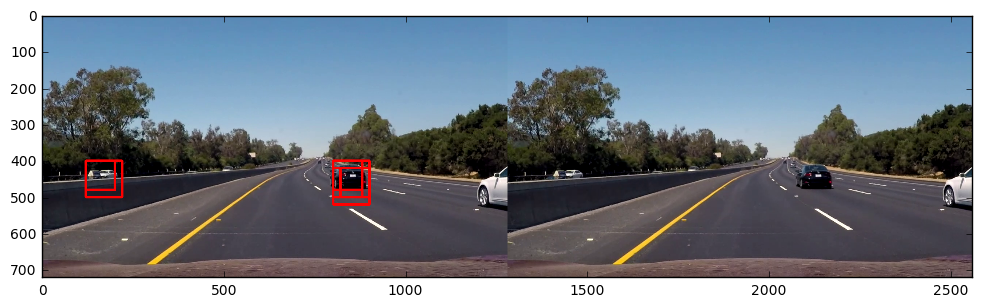

[]


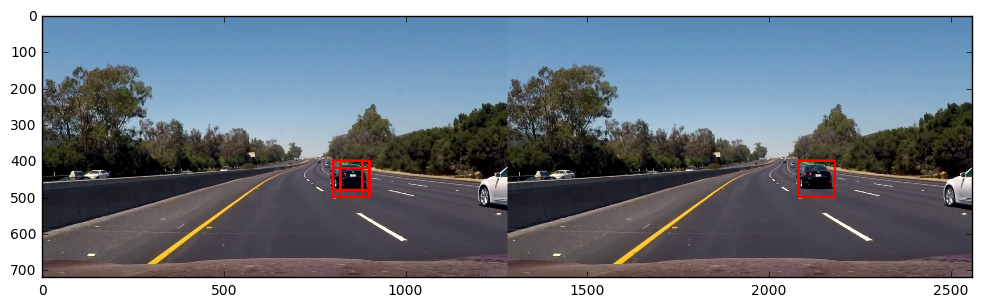

[((800, 400), (900, 500))]


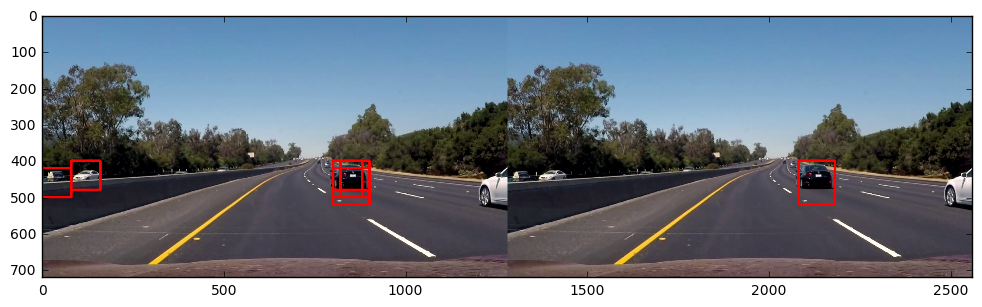

[((800, 400), (900, 520))]


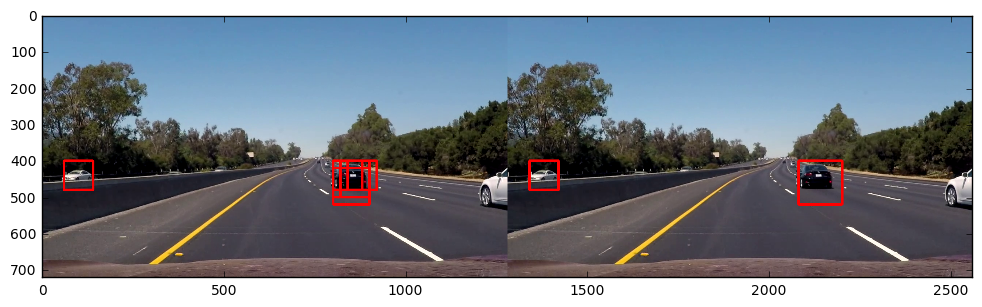

[((800, 400), (920, 520)), ((60, 400), (140, 480))]


In [96]:
cap = cv2.VideoCapture("project_video.mp4") #video_name is the video being called
for fn in range(1179,1183): # enter the range of frames to view
    cap.set(1,fn); # Where frame_no is the frame you want
    ret, frame = cap.read() # Read the frame
    cv2.imwrite('test1179.jpg',frame)
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    aug_frame=car_detector.pipeline(frame, dbg=True)
    
    aug_frame=cv2.cvtColor(aug_frame,cv2.COLOR_RGB2BGR)
    cv2.putText(aug_frame, "Frame "+str(fn), (400, 450),
           cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)    
    
    cv2.imshow('window_name', aug_frame) # show frame on window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    


In [27]:
cv2.destroyAllWindows()  

# Video

In [114]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip_output = clip1.fl_image(car_detector.pipeline) #NOTE: this function expects color images!!
%time clip_output.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [51:43<00:02,  2.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

Wall time: 51min 43s
